In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [14]:
class Value:
    """
    A scalar value that supports automatic differentiation.

    Each Value object represents a node in a computational graph.
    It stores:
    - the numerical value (data)
    - the gradient of some final output w.r.t. this value (grad)
    - a backward function that propagates gradients to its parents
    - references to parent nodes (children in the graph)
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Create a Value node.

        Parameters:
        - data: the scalar numerical value
        - _children: parent Value nodes used to compute this Value
        - _op: string describing the operation that produced this Value
        - label: optional name (useful for debugging / visualization)
        """
        self.data = data              # numerical value
        self.grad = 0.0               # gradient d(output)/d(this)
        self._backward = lambda: None # function to backpropagate gradients
        self._prev = set(_children)   # parent nodes in the computation graph
        self._op = _op                # operation that produced this node
        self.label = label            # optional label

    def __repr__(self):
        """
        String representation for debugging.
        """
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """
        Addition of two Value objects (or Value + scalar).

        Forward:
            out = self.data + other.data

        Backward:
            d(out)/d(self) = 1
            d(out)/d(other) = 1
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Gradient distributes equally to both operands
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        """
        Multiplication of two Value objects (or Value * scalar).

        Forward:
            out = self.data * other.data

        Backward:
            d(out)/d(self) = other.data
            d(out)/d(other) = self.data
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        """
        Power operation: self ** other, where other is a scalar.

        Forward:
            out = self.data ** other

        Backward:
            d(out)/d(self) = other * self.data ** (other - 1)
        """
        assert isinstance(other, (int, float)), "only supporting int/float pow"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        """
        Reversed multiplication to support: scalar * Value
        """
        return self * other
    
    def __truediv__(self, other):
        """
        Division implemented as multiplication by reciprocal.

        self / other = self * other**(-1)
        """
        return self * other ** -1
    
    def __sub__(self, other):
        """
        Subtraction implemented as addition of negative.

        self - other = self + (-other)
        """
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def tanh(self):
        """
        Hyperbolic tangent activation function.

        Forward:
            tanh(x)

        Backward:
            d(tanh(x))/dx = 1 - tanh(x)^2
        """
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        """
        Exponential function.

        Forward:
            out = e^x

        Backward:
            d(e^x)/dx = e^x
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        """
        Perform backpropagation starting from this node.

        Steps:
        1. Build a topological ordering of the computation graph
           (ensures children are processed before parents)
        2. Initialize gradient of the final output to 1
        3. Traverse nodes in reverse topological order and apply
           their stored _backward functions
        """
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        # Build topological ordering
        build_topo(self)

        # Seed gradient (d(self)/d(self) = 1)
        self.grad = 1.0

        # Backpropagate gradients
        for node in reversed(topo):
            node._backward()


In [33]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %4f}" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## 1. Defining a Neuron, Layer and Multilayer Perceptron

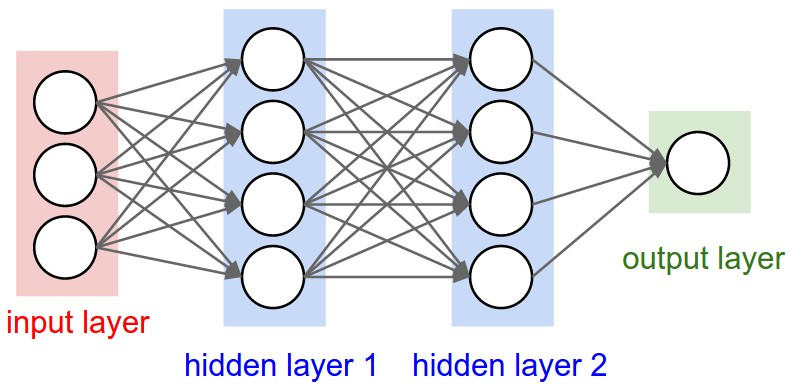

In [31]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
        self.b = Value(random.uniform(-1,1)) # bias

    def __call__(self, x):
        """
        Will return something upon calling the class (ex. Neuron(x) -> return 
        out)
        """
        # w * x + b
        pairs = zip(self.w, x) # Pairs up (w_i, x_i) 
        act = sum((wi*xi for wi, xi in pairs), self.b) # starts the sum from b
        out = act.tanh()
        return out

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [32]:

x = [2.0, 3.0, -1.0] # input layer
n = MLP(3, [4, 4, 1]) # 3 inputs into 2 layers of 4 and 1 output
n(x)

Value(data=-0.011443914215927957)

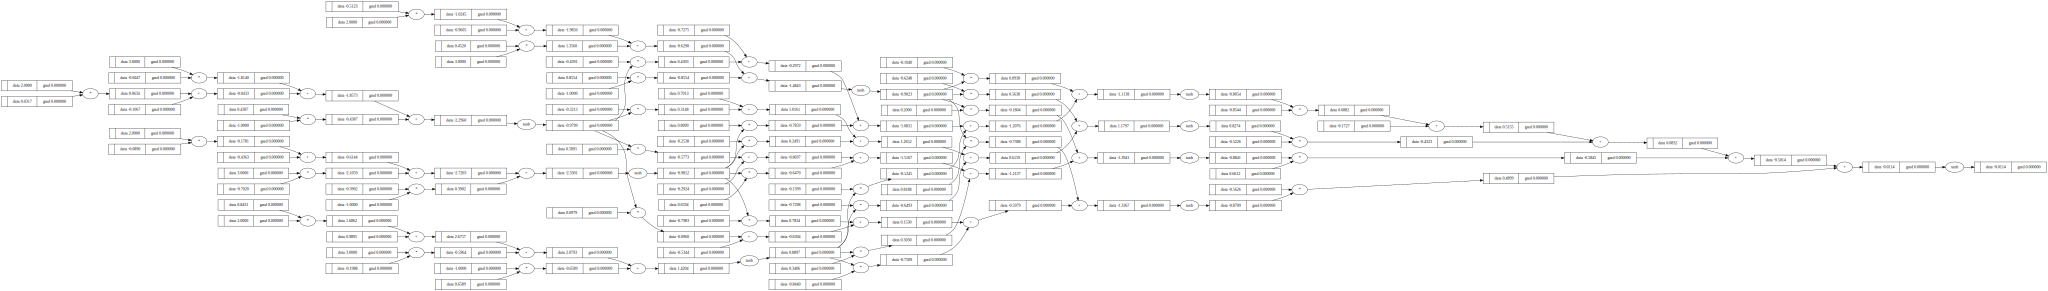

In [34]:
draw_dot(n(x))

In [ ]:
# Sample dataset 1

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.011443914215927957),
 Value(data=0.7413493088830353),
 Value(data=0.336308424664892),
 Value(data=-0.016595871722805484)]

## 2. Loss function and Gradient Descent

Assuming we have a set of inputs and a desired outputs, we now need to codify how the NN can tweak the weights in order to change ```ypred``` into ```ys```. We need to come up with a loss function that measures the model performance.

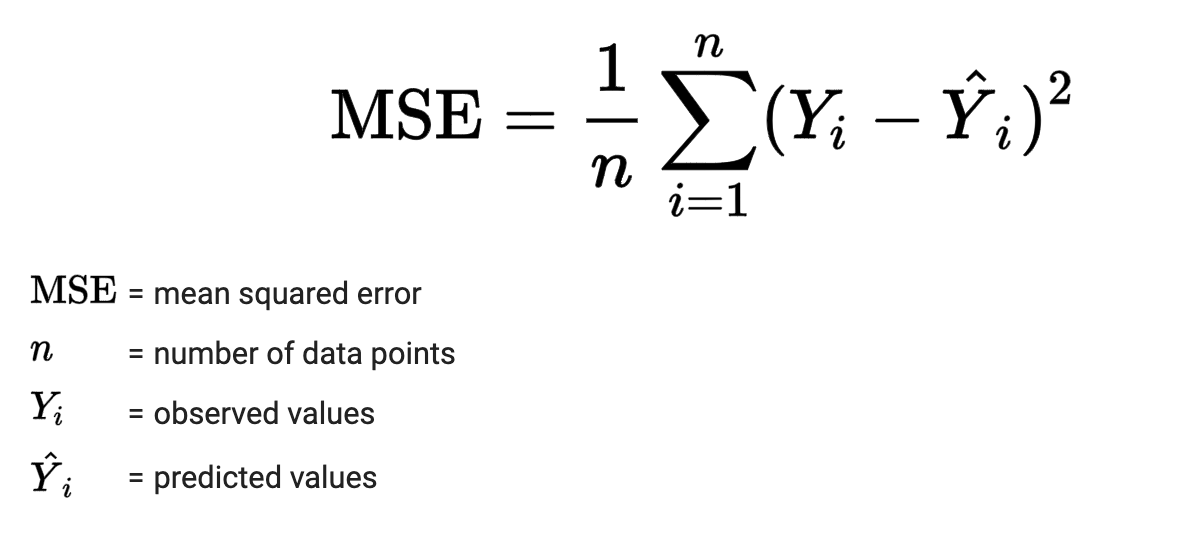

In [37]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # for y grand truth and y output in the paired gt and predictions, we subtract them and square them

[Value(data=1.0230187916044373),
 Value(data=3.0322974155474243),
 Value(data=1.7857202058303652),
 Value(data=1.0334671664038506)]

The closer to the target the smaller the number, squaring ensures we always have a positive value, no matter the sign.

In [38]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.874503579386078)

We now have the total loss that needs to be **minimised**.

In [39]:
loss.backward()

By running the above command we are able to compute the gradient of each individual input neurons, thanks to this we can understand how much to tweak the weights in order to decreade the loss function.

In [ ]:
n.layers[0].neurons[0].w[0].grad # example of the first neuron gradient influencing the loss function

1.8290197567690418

We now want to collect all the parameters of the NN all in one array:

In [42]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
        self.b = Value(random.uniform(-1,1)) # bias

    def __call__(self, x):
        """
        Will return something upon calling the class (ex. Neuron(x) -> return 
        out)
        """
        # w * x + b
        pairs = zip(self.w, x) # Pairs up (w_i, x_i) 
        act = sum((wi*xi for wi, xi in pairs), self.b) # starts the sum from b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        """
        For each neuron in the neruons list returns each neuron parameters.
        """
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [48]:
# Sample dataset 2
n = MLP(3, [4, 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9830245195619969),
 Value(data=-0.9771084345365817),
 Value(data=-0.9865945114507324),
 Value(data=-0.9717344972480204)]

In [49]:
len(n.parameters())

41

In [50]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.820826903714603)

In [51]:
loss.backward()

In [55]:
n.layers[0].neurons[0].w[0].grad 

0.07423017375302021

In [56]:
n.layers[0].neurons[0].w[0].data

0.5248056810042695

In [57]:
for p in n.parameters():
    # we need to add a tiny update (ex. 0.001) based on the direction provided 
    # by the gradient, which represents a vector pointing in the direction of 
    # increaded loss. Hence the update must be negative as we want to minimise 
    # the loss
    p.data += -0.001 * p.grad

We can see the value of the first neuron has decresed, this is correct as the neuron bared a positive gradient (0.07423017375302021), hence decreasing it will make it contribute less to the loss function, hence minimise it.

In [59]:
n.layers[0].neurons[0].w[0].data

0.5247314508305165

We revaluate the loss value and see it goes from Value(data=7.820826903714603) to Value(data=7.819164033535923), hence decreasing by 0.0017.

In [60]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.819164033535923)

Now we need to iterate the process

In [62]:
loss.backward()

for p in n.parameters():
    p.data += -0.001 * p.grad

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.817475178682283)

In [63]:
loss.backward()

for p in n.parameters():
    p.data += -0.001 * p.grad

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.81489530922966)

Etc. etc. etc. 

This is called **gradient descent**.

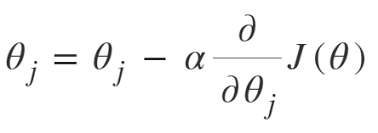

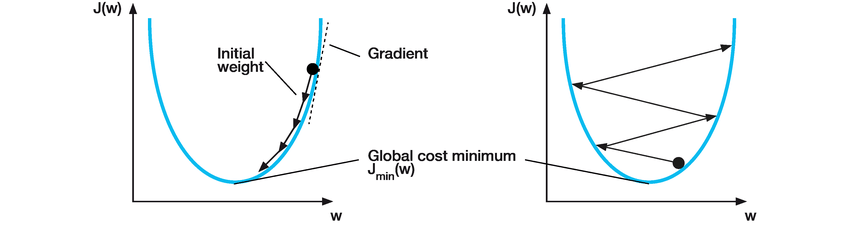
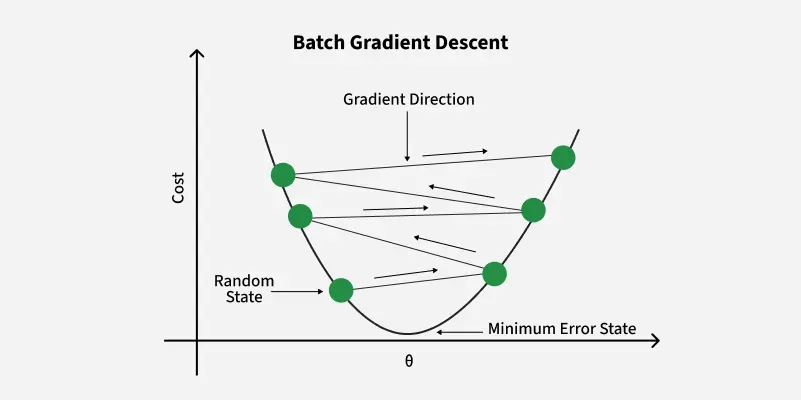

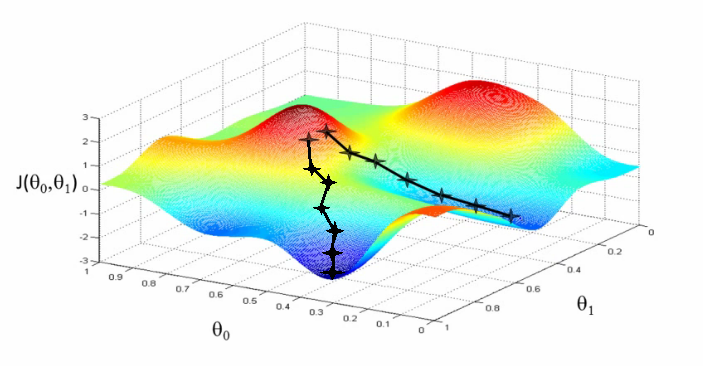

We can speed up the process by increasing the learning rate, but being careful of not overshooting [Image 2].

In [72]:
loss.backward()

for p in n.parameters():
    p.data += -0.1 * p.grad

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.15486686568733288)

In [73]:
ypred

[Value(data=0.7399430523316566),
 Value(data=-0.9684809255246891),
 Value(data=-0.9820387119091333),
 Value(data=0.7068768352192306)]

We can see the loss is extremely low, hence the prediction values are closer to the desired targets ys = [1.0, -1.0, -1.0, 1.0] 

## 3. Training loop

In [74]:
# Sample dataset 3
n = MLP(3, [4, 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

# Loop with 20 steps and 0.05 learning rate

for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.0096337375235995
1 2.4374072535984688
2 1.2518659066888693
3 0.267895263500091
4 0.13151536511869902
5 0.08050747828024671
6 0.04577054711628445
7 0.024834438603735357
8 0.015160242463300364
9 0.017690760203587112
10 0.015472078600203675
11 0.0012492513435927255
12 0.00016637773490935234
13 3.4799005353568036e-05
14 9.370586321484734e-06
15 2.9648276219585746e-06
16 1.0621910246312947e-06
17 4.214496201504741e-07
18 1.8135267758958654e-07
19 8.289504503045081e-08


In [75]:
ypred

[Value(data=0.9999129754211147),
 Value(data=-0.9998151042654658),
 Value(data=-0.9998151793270275),
 Value(data=0.9999164736335441)]

The value of ypred is extremely accurate. However, we forgot to zero grad.

In this training loop, a very common (and subtle) mistake is **forgetting to reset the gradients to zero before calling `backward()`**.

---

## What happens conceptually

In most autodiff systems (including PyTorch-like engines and micrograd-style implementations), **gradients accumulate by default**.

Formally, for each parameter ( p ):

$$
p.\text{grad} \leftarrow p.\text{grad} + \frac{\partial \text{loss}}{\partial p}
$$

This means that every time you call `loss.backward()`, the newly computed gradients are **added** to the gradients already stored in `p.grad`.

---

## Why this is a problem in your loop

Your training loop does:

1. Forward pass
2. `loss.backward()`
3. Parameter update

But it **never clears `p.grad`** before the next iteration.

So at iteration ( k ), the gradient used to update parameters is actually:

$$
\sum_{i=1}^{k} \frac{\partial \text{loss}_i}{\partial p}
$$

instead of just:

$$
\frac{\partial \text{loss}_k}{\partial p}
$$

---

## Practical consequences

* Gradients grow larger and larger over iterations
* Parameter updates become increasingly aggressive
* Training becomes unstable or diverges
* The printed loss may:

  * oscillate
  * explode
  * decrease for the wrong reasons

This behavior is **not gradient descent anymore**, but gradient descent with unintended gradient accumulation.

In [76]:
# Sample dataset 3
n = MLP(3, [4, 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

# Loop with 20 steps and 0.05 learning rate

for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.150562215109902
1 4.229345475850643
2 3.799889285686243
3 3.3829960957242564
4 2.634643153190865
5 1.4328630468322991
6 0.6771309938151437
7 0.3823686095191728
8 0.2524550672500777
9 0.18661370053928797
10 0.1467517397867545
11 0.12033617470026468
12 0.10167066096855351
13 0.08783981751498547
14 0.0772114673460853
15 0.06880618209427153
16 0.062003023051755715
17 0.05639041235540381
18 0.05168534036937837
19 0.04768711984723739


In [77]:
ypred

[Value(data=0.9665619873017834),
 Value(data=-0.890576742950926),
 Value(data=-0.8482337849238984),
 Value(data=0.8924705345857329)]